# Meta model

## Load required modules and functions

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [181]:
import pickle

In [182]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

### Settings

In [183]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

## Load and prepare the data

In [184]:
### Load dataset
data = datasets.data_original()
### Feature engineering 
data = features.engineer(data)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Scaling the data 

In [185]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_.columns)



## Load and evaluate all models

In [186]:
models = {}

### Logistic regression

In [187]:
models["Logistic"] = pickle.load(open("models/logistic_RFE9.pkl", "rb"))

In [188]:
n_features = models["Logistic"].coef_.shape[1]
n_features

9

In [189]:
rfe_features = pickle.load(open("models/rfe_features_250103.pkl", "rb"))[9]

In [190]:
print(rfe_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']


### Random Forest

In [191]:
with open("models/random_forest_gridsearch_241218.pkl", "rb") as file:
    models["RandomForest"] = pickle.load(file)

### KNN ###

In [192]:
with open("models/knn.pkl", "rb") as file:
    models["Knearestneighbors"] = pickle.load(file)

## Evaluate the models

In [193]:

y_train = y_train_
y_test = y_test_

y_pred_train = {}
y_proba_train = {}

y_pred_test = {}
y_proba_test = {}

### Data preprocessing

In [194]:
# by default we assing unscaled raw data to each model
X_train_preprocessed = {modelname: X_train_ for modelname in models}
X_test_preprocessed = {modelname: X_test_ for modelname in models}



In [195]:
# Logistic : scaled dataset, with only selected features
X_train_preprocessed["Logistic"] = X_train_scaled[rfe_features]
X_test_preprocessed["Logistic"] = X_test_scaled[rfe_features]


### Evaluate all models

In [196]:
for model_name in models:
    model = models[model_name]

    X_train = X_train_preprocessed[model_name]
    y_pred_train[model_name] = model.predict(X_train)
    y_proba_train[model_name] = model.predict_proba(X_train)[:,1]

    X_test = X_test_preprocessed[model_name]
    y_pred_test[model_name] = model.predict(X_test)
    y_proba_test[model_name] = model.predict_proba(X_test)[:,1]

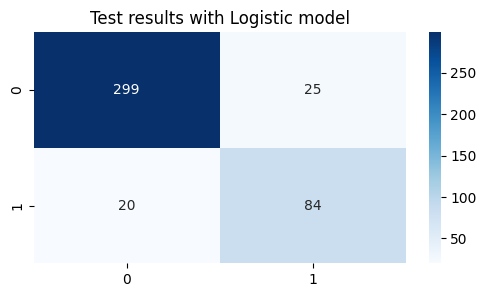

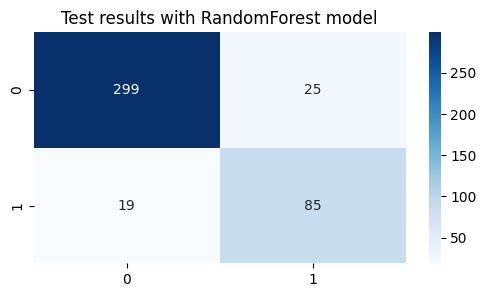

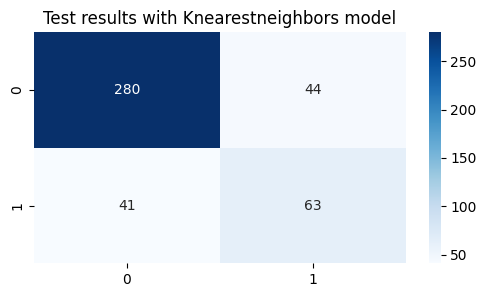

In [197]:
for model_name in models:
    sns.heatmap(confusion_matrix(y_test,y_pred_test[model_name]), annot = True, cmap = "Blues", fmt='d')
    plt.title("Test results with " + model_name + " model")
    plt.show()


### Evaluation scores


In [198]:
results_test_models_list = []

for model_name in models : 
    y_pred = y_pred_test[model_name]

    results_test = {
        "model": model_name,
        "accuracy": accuracy_score(y_test,y_pred),
        "recall": recall_score(y_test,y_pred),
        "selectivity": recall_score(y_test,y_pred,pos_label = 0),
        "f1": f1_score(y_test,y_pred),
        "f3": fbeta_score(y_test,y_pred,beta = 3),
        "precision": precision_score(y_test,y_pred),
        "NPV": precision_score(y_test,y_pred, pos_label = 0)
    }

    results_test_models_list.append(results_test)

results_test_models_df = pd.DataFrame(results_test_models_list)


In [199]:
print(results_test_models_df)

               model  accuracy    recall  selectivity        f1        f3  \
0           Logistic  0.894860  0.807692     0.922840  0.788732  0.803828   
1       RandomForest  0.897196  0.817308     0.922840  0.794393  0.812620   
2  Knearestneighbors  0.801402  0.605769     0.864198  0.597156  0.604027   

   precision       NPV  
0   0.770642  0.937304  
1   0.772727  0.940252  
2   0.588785  0.872274  


## Meta model

### Stack the model evaluations

For each patient we evaluate each model with the probability of being infected

In [200]:
X_train_stacked = pd.DataFrame(y_proba_train)
X_test_stacked = pd.DataFrame(y_proba_test)

print(X_train_stacked.shape, X_test_stacked.shape)

(1711, 3) (428, 3)


In [201]:
X_train_stacked.head()

,Logistic,RandomForest,Knearestneighbors
0,0.002483,0.057052,0.0
1,0.653643,0.769390,0.0
2,0.354624,0.084080,0.0
3,0.295284,0.280225,0.0
4,0.022432,0.064569,0.0


In [202]:
X_train_stacked.Knearestneighbors.value_counts()

Knearestneighbors
0.000000    1283
1.000000     375
0.666667      45
0.333333       8
Name: count, dtype: int64

### Visualize the stacked evaluations of the base models

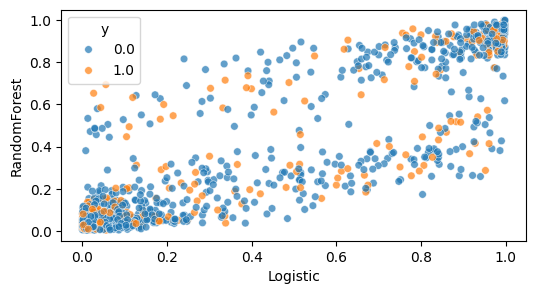

In [203]:
### a simple scatterplot

base_model_scatter = X_train_stacked.copy()
base_model_scatter['y'] = y_train

sns.scatterplot(data=base_model_scatter, x='Logistic', y='RandomForest', hue='y', alpha = 0.7, s=30)
plt.show()

### Logit transform the stacked model

The evaluations of the models are expressed as probabilities, so in $[0,1]$. We want to transform them into log-odd ratios to $[-\infty,\infty]$ via the logit function

In [204]:
def logit(X):
    epsilon = 1e-6
    X_clipped = np.clip(X, epsilon, 1 - epsilon)
    return np.log(X_clipped / (1 - X_clipped))

In [205]:
X_train_stacked_logodd = X_train_stacked.apply(logit)
X_test_stacked_logodd = X_test_stacked.apply(logit)

### Train the meta model

In [206]:
from sklearn.naive_bayes import GaussianNB

meta_classifier = GaussianNB()

meta_classifier.fit(X_train_stacked_logodd,y_train)

GaussianNB()

### Evaluate the meta model

In [207]:
results_test_models_list_meta = results_test_models_list.copy()


y_pred = meta_classifier.predict(X_test_stacked_logodd)

results_test = {
    "model": "meta",
    "accuracy": accuracy_score(y_test,y_pred),
    "recall": recall_score(y_test,y_pred),
    "selectivity": recall_score(y_test,y_pred,pos_label = 0),
    "f1": f1_score(y_test,y_pred),
    "f3": fbeta_score(y_test,y_pred,beta = 3),
    "precision": precision_score(y_test,y_pred),
    "NPV": precision_score(y_test,y_pred, pos_label = 0)
}

results_test_models_list_meta.append(results_test)

results_test_models_df_meta = pd.DataFrame(results_test_models_list_meta)

In [208]:
y_pred_test_meta = y_pred

In [209]:
results_test_models_df_meta

,model,accuracy,recall,selectivity,f1,f3,precision,NPV
0,Logistic,0.894860,0.807692,0.922840,0.788732,0.803828,0.770642,0.937304
1,RandomForest,0.897196,0.817308,0.922840,0.794393,0.812620,0.772727,0.940252
2,Knearestneighbors,0.801402,0.605769,0.864198,0.597156,0.604027,0.588785,0.872274
3,meta,0.873832,0.836538,0.885802,0.763158,0.820755,0.701613,0.944079


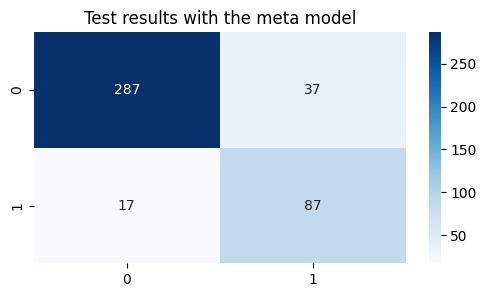

In [210]:
sns.heatmap(confusion_matrix(y_test,y_pred_test_meta), annot = True, cmap = "Blues", fmt='d')
plt.title("Test results with the meta model")
plt.show()

## Visualize decision boundary with two base models

In [211]:
# let's boundary plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_decision_boundary(fitted_meta_model, Xstackedtrain, ytrain, figsize = (10,6)):
    """
    np2darray.ravel() efficiently flattens the array
    np.c_ is like clumn_stack: it acts as zip(), into a 2d array
    """
    df = Xstackedtrain.copy()
    df['y'] = ytrain

    # Create a meshgrid of points
    ## xx.shape == (M,N) where M,N are the number of gridpoints nd the X/Y axis respectively
    x_min, x_max, y_min, y_max = -11, 7.5, -7, 7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    ## xx.ravel().shape == (M*N,)
    ## xy.shape = (M*N,2)
    xy = np.c_[xx.ravel(), yy.ravel()]   
    xy = pd.DataFrame(xy,columns = models.keys())  
    
    # Predict on the grid
    Z = meta_classifier.predict(xy)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=figsize)
    ## scatterplot the base model predictions
    sns.scatterplot(data=df, x='Logistic', y='RandomForest', hue='y', s= 30, alpha = 0.6)
    ## countrouf the meta model prediction
    plt.contourf(xx, yy, Z, alpha=0.2, levels=1)
    plt.title("Decision boundary of the meta model")
    plt.show()

In [212]:
#plot_decision_boundary(meta_classifier, X_train_stacked_logodd, y_train)


## Vanilla models

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier




In [214]:
'''models_vanilla = {}
models_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)
models_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)
models_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)
models_vanilla["KNearestNeighbors"] = KNeighborsClassifier()
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)'''

'models_vanilla = {}\nmodels_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)\nmodels_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)\nmodels_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)\nmodels_vanilla["KNearestNeighbors"] = KNeighborsClassifier()\nmodels_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)'

In [215]:
models_vanilla = {}
models_vanilla["RandomForest"] =models["RandomForest"]
models_vanilla["KNearestNeighbors"] = models["Knearestneighbors"]
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [216]:
from src.model_selection import cv_accuracy_recall

In [217]:
cv_vanilla = []
for modelname in models_vanilla:
    cv_vanilla.append(cv_accuracy_recall(X_train_scaled,y_train_, models_vanilla[modelname], modelname + "_vanilla"))
cv_vanilla = pd.DataFrame(cv_vanilla)
cv_vanilla

,accuracy,recall,model
0,0.878426,0.692943,RandomForest_vanilla
1,0.829918,0.491538,KNearestNeighbors_vanilla
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla


### Undersampled training vanilla

In [218]:
models_vanilla = {}
models_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)
models_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)
models_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)
models_vanilla["KNearestNeighbors"] = KNeighborsClassifier()
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [219]:
models_vanilla = {}
models_vanilla["RandomForest"] =models["RandomForest"]
models_vanilla["KNearestNeighbors"] = models["Knearestneighbors"]
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [220]:
models

{'Logistic': LogisticRegression(random_state=42),
 'RandomForest': RandomForestClassifier(min_samples_leaf=2, n_estimators=500),
 'Knearestneighbors': KNeighborsClassifier(metric='manhattan', n_neighbors=3)}

In [221]:
def sample_balance_Xy(X,y, with_reindex = False):
    df = X.copy()
    df['infected'] = y
    df_infected = df[df['infected']==1] 
    df_not_infected = df[df['infected']==0]

    num_infected = df_infected.shape[0]
    df_sample_not_infected = df_not_infected.sample(num_infected, random_state=42)

    df_balanced = pd.concat([df_infected,df_sample_not_infected])
    # we shuffle it once more at the end.
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    if with_reindex:
        df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    else:
        df_balanced = df_balanced.sample(frac=1)
    X_balanced = df_balanced.drop(columns=['infected'])
    y_balanced = df_balanced['infected']
    return X_balanced,y_balanced


In [222]:
X_train_balanced, y_train_balanced = sample_balance_Xy(X_train_scaled, y_train_)

In [223]:
X_train_balanced.shape

(676, 24)

In [224]:
cv_vanilla_balanced = []
for modelname in models_vanilla:
    cv_vanilla_balanced.append(cv_accuracy_recall(X_train_balanced,y_train_balanced, models_vanilla[modelname], modelname + "_balanced"))
cv_vanilla_balanced = pd.DataFrame(cv_vanilla_balanced)
cv_vanilla_balanced

,accuracy,recall,model
0,0.488137,0.484987,RandomForest_balanced
1,0.489651,0.479368,KNearestNeighbors_balanced
2,0.519270,0.541440,ArtificialNeuralNetworkMLP_balanced


## Oversampling vanilla

In [225]:
from imblearn.over_sampling import SMOTENC


In [226]:
from imblearn.pipeline import Pipeline, make_pipeline

cat_features = [c for c in X_train_ if X_train_[c].nunique() < 5]
smote_nc =  SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)




In [227]:
cv_vanilla_smote = []
for modelname in models_vanilla:
    model = models_vanilla[modelname]
    X_ = X_train_scaled.copy()
    y_ = y_train_
    imba_pipeline = make_pipeline(smote_nc, model)
    cv_vanilla_smote.append(cv_accuracy_recall(X_,y_, imba_pipeline, modelname + "_smote"))
cv_vanilla_smote = pd.DataFrame(cv_vanilla_smote)
cv_vanilla_smote

c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. Fro

,accuracy,recall,model
0,0.875507,0.793718,RandomForest_smote
1,0.805364,0.659409,KNearestNeighbors_smote
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote


In [228]:
all_cv = pd.concat([cv_vanilla,cv_vanilla_smote])
all_cv

,accuracy,recall,model
0,0.878426,0.692943,RandomForest_vanilla
1,0.829918,0.491538,KNearestNeighbors_vanilla
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla
0,0.875507,0.793718,RandomForest_smote
1,0.805364,0.659409,KNearestNeighbors_smote
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote


In [229]:
def firstme(word):
    return word.split("_")[0]

all_cv["model_base"] = all_cv["model"].apply(firstme)
all_cv

,accuracy,recall,model,model_base
0,0.878426,0.692943,RandomForest_vanilla,RandomForest
1,0.829918,0.491538,KNearestNeighbors_vanilla,KNearestNeighbors
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla,ArtificialNeuralNetworkMLP
0,0.875507,0.793718,RandomForest_smote,RandomForest
1,0.805364,0.659409,KNearestNeighbors_smote,KNearestNeighbors
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote,ArtificialNeuralNetworkMLP


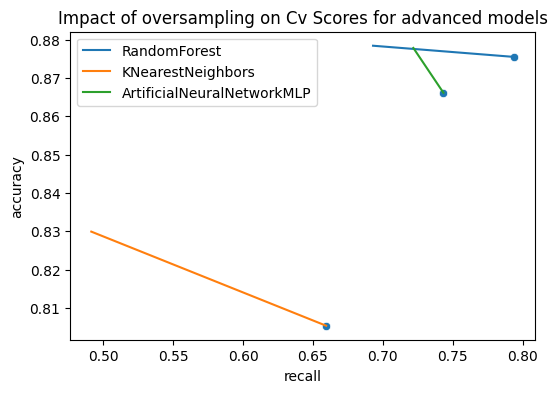

In [234]:
plt.figure(figsize = (6,4))
sns.lineplot(data = all_cv, x= "recall", y="accuracy",hue = "model_base")
sns.scatterplot(data=cv_vanilla_smote, x = "recall", y= "accuracy", legend = True)
plt.title("Impact of oversampling on Cv Scores for advanced models")
plt.show()